# Discriminative vs. Generative Modeling for Cardiovascular Risk Prediction 


### adding libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Loading dataset


In [4]:
# Step 1: Load the dataset
df = pd.read_csv("data/heart_disease_uci.csv")  # replace with your actual file path if needed

In [5]:
df

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,916,54,Female,VA Long Beach,asymptomatic,127.0,333.0,True,st-t abnormality,154.0,False,0.0,NaN,NaN,NaN,1
916,917,62,Male,VA Long Beach,typical angina,NaN,139.0,False,st-t abnormality,NaN,NaN,NaN,NaN,NaN,NaN,0
917,918,55,Male,VA Long Beach,asymptomatic,122.0,223.0,True,st-t abnormality,100.0,False,0.0,NaN,NaN,fixed defect,2
918,919,58,Male,VA Long Beach,asymptomatic,NaN,385.0,True,lv hypertrophy,NaN,NaN,NaN,NaN,NaN,NaN,0


# Task 1: Data Exploration & Gaussian Fitting

### • Handle missing or invalid values via deletion or imputation. 


In [6]:
# Step 2: Drop irrelevant columns
# df.drop(columns=["id", "dataset"], inplace=True)

# Step 3: Binarize target column
df["target"] = df["num"].apply(lambda x: 1 if x > 0 else 0)
# df.drop(columns=["num"], inplace=True)

# Step 4: Drop rows with any missing values
df.dropna(inplace=True)

# Step 5: Check remaining shape and confirm no missing values
print("Data shape after dropping missing values:", df.shape)
print("Remaining missing values:\n", df.isnull().sum())

Data shape after dropping missing values: (299, 17)
Remaining missing values:
 id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
target      0
dtype: int64


### • Plot distributions (histogram or KDE) of all features per class. 


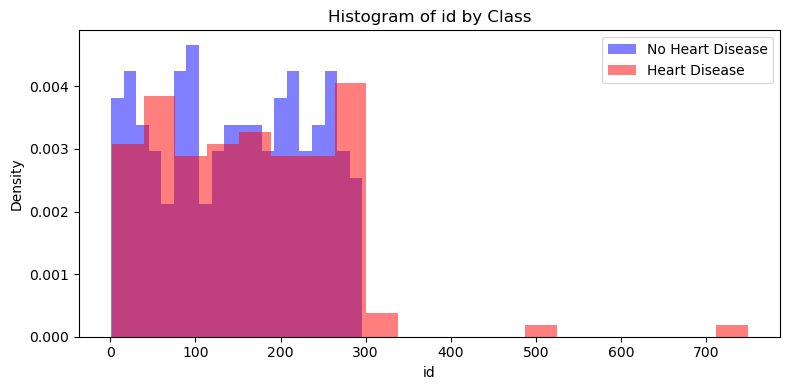

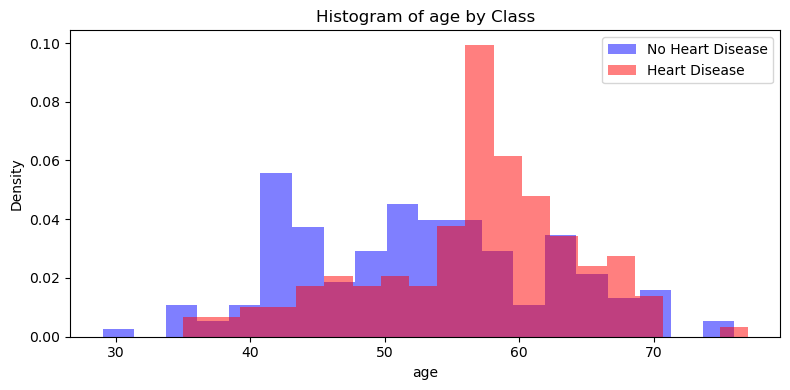

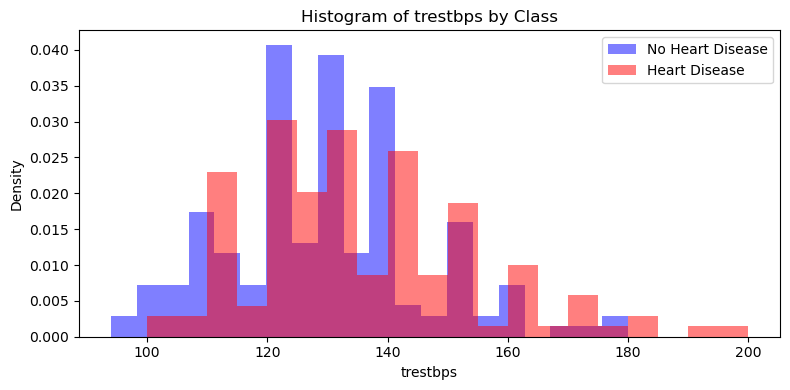

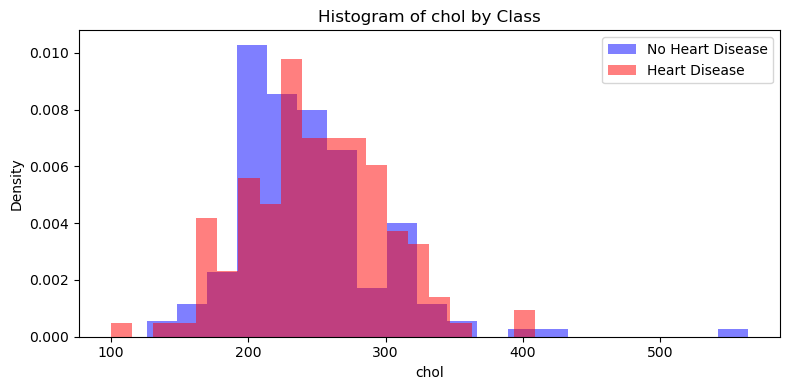

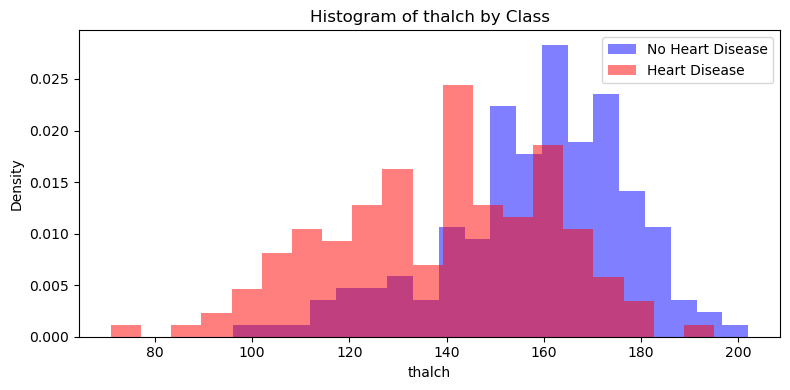

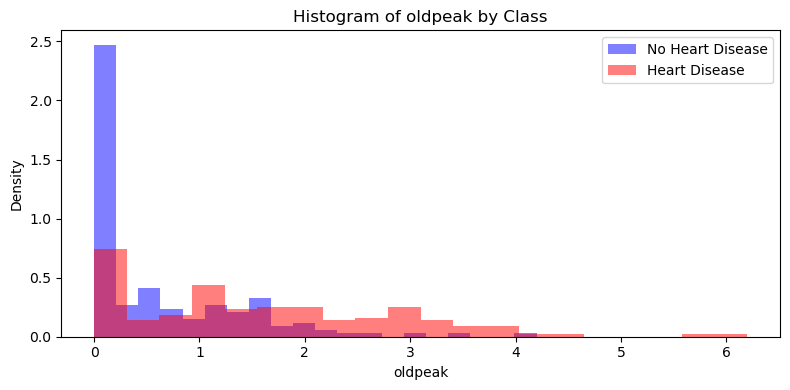

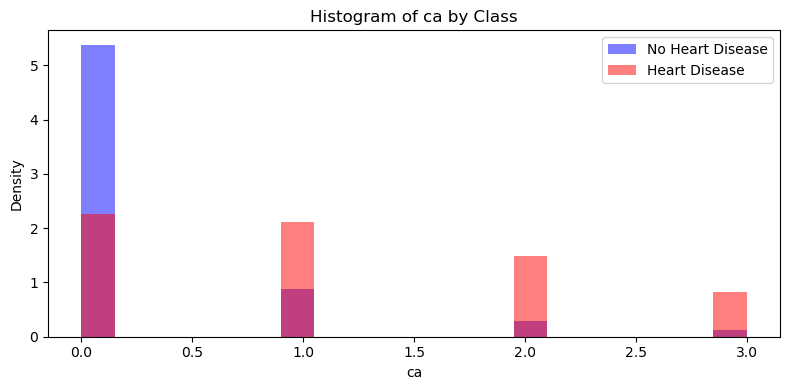

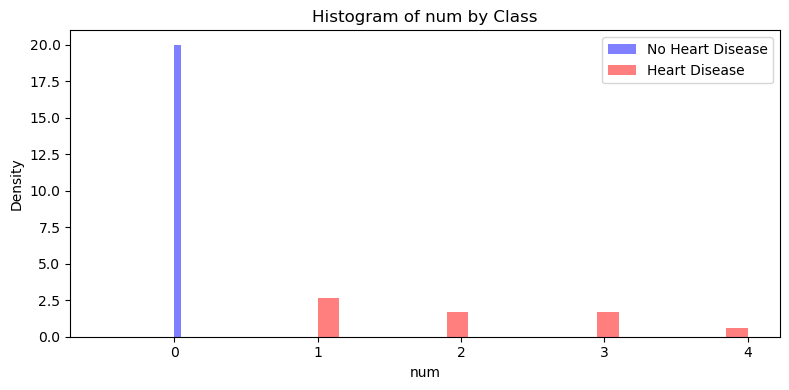

In [7]:
# Get list of numeric columns (excluding target)
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns.drop("target")

# Plot histogram for each numeric column, separated by class
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    plt.hist(df[df["target"] == 0][col], bins=20, alpha=0.5, label="No Heart Disease", color="blue", density=True)
    plt.hist(df[df["target"] == 1][col], bins=20, alpha=0.5, label="Heart Disease", color="red", density=True)
    plt.title(f"Histogram of {col} by Class")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()


### • Select two informative features (e.g., chol and thalach). 


In [8]:
# Select the two features: 'chol' and 'thalch'
selected_features = ["chol", "thalch", "target"]

# Extract subset
df_selected = df[selected_features]

# Display first few rows
print(df_selected.head())

    chol  thalch  target
0  233.0   150.0       0
1  286.0   108.0       1
2  229.0   129.0       1
3  250.0   187.0       0
4  204.0   172.0       0
